# Predicting Snow Water Equivalent in regions in Western United States


**Estimating snow water equivalent (SWE) at a high spatiotemporal resolution over the Western U.S. using near real-time data sources**

**Author**: Hanis Zulmuthi

May 2022

![http://url/to/img.png](https://i.pinimg.com/originals/9d/d6/5f/9dd65ffbb09b6bb44e5cbb47df654fd3.jpg)
Source: [Reddit.com](https://www.reddit.com/r/EarthPorn/comments/a6ewla/snow_and_flowing_water_is_one_of_the_most_magical/?utm_source=ifttt)

## Overview

This project budded from a competition titled [Snowcast Showdown](https://www.drivendata.org/competitions/90/competition-reclamation-snow-water-eval/page/431/) on [Driven Data](https://www.drivendata.org/). The goal of the project is to develop a predictive model to estimate the distribution of Snow Water Equivalent (SWE)  at a high spatiotemporal resolution over the Western U.S. This predictive model will assist NOAA in their [National Integrated Drought Information System (NIDIS)](https://www.drought.gov/), an initiative to monitor snow drought in the wester United States. 

## Introduction

Snow Water Equivalent (SWE) is a common snowpack measurement used by hydrologists and water managers to gage amount of liquid water contained within snowpack. It is equal to the amount of water contained within the snowpack when it melts. It can be thought of as the depth of water that would theoretically result if you melted the entire snowpack instantaneously [[1]](https://www.nrcs.usda.gov/wps/portal/nrcs/detail/nv/snow/?cid=nrcseprd1746821#:~:text=Snow%20Water%20Equivalent%20(SWE)%20is,the%20snowpack%20when%20it%20melts.).  

Water in a snow pack is determined by depth, density, type of snow, changes in the pack, previous freeze/thaw cycles, recent rainfall events, etc.  Available water is the amount of water that would be released if the snow pack melted.  SWE is an important measure of availability of water resources, since it relates to the runoff of rivers and variations in groundwater levels, so knowing how much water is available in the snow pack is valuable for those managing reservoirs and flood forecasting [[2]](https://www.campbellsci.ca/snow-water-equivalent-measurement)[[3]](http://www.eumetrain.org/data/3/358/navmenu.php?tab=7&page=1.0.0#:~:text=Climatology%20of%20snow%20cover%20and%20snow%20water%20equivalent,-Table%20of%20Contents&text=SWE%20is%20an%20important%20measure,the%20age%20of%20snow%20cover.).

[Reports](https://www.drought.gov/drought-status-updates/water-year-2021-snow-drought-conditions-summary-and-impacts-west) by NOAA (through their [National Integrated Drought Information System (NIDIS)](https://www.drought.gov/) program) on the intensifying snow drought over western U.S raises the alarm on the importance of predicting SWE as accurately possible, especially for remote, high elevation areas where manual ground measure measurements are not feasible. It was reported that the loww snowpack, rapid and early snow melts and poor runoffs had resulted in a significant drop in water supply in the summer of 2021 (fig 1).

![water-reservoir](../figures/reservoir-storage-may-1-2021.jpeg)

Source: [NIDIS, Drought.gov](https://www.drought.gov/drought-status-updates/water-year-2021-snow-drought-conditions-summary-and-impacts-west)


## Data Understanding


**Historical Ground Measures data:** Ground measures help provide regularly collected, highly accurate point estimates of SWE at designated stations. Ground measures data range from 2013-2019 and 2020-2021 was provided in [ground_measures_train_features.csv](./data/ground_measures_train_features.csv) and [ground_measures_test_features.csv](./data/ground_measures_test_features.csv). The ground measures data are from [Snow Telemetry (SNOTEL)](https://www.nrcs.usda.gov/wps/portal/wcc/home/) and [California Data Exchange Center (CDEC)](https://cdec.water.ca.gov/). The dataset used from these sources is available in this repo [here](./data/).

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;***[SNOTEL](https://www.nrcs.usda.gov/wps/portal/wcc/home/):*** The Snow Telemetry (SNOTEL) program consists of automated and semi-automated data collection sites across the Western U.S.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;***[CDEC](https://cdec.water.ca.gov/):*** The California Data Exchange Center (CDEC) facilitates the collection, storage, and exchange of hydrologic and climate information to support real-time flood management and water supply needs in California. CDEC operates data collection sites similar to SNOTEL within California.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Ground-based sites from SNOTEL and CDEC are used both as an input data source and in ground truth labels for our predictive model. ***Note that, sites that we are predicting SWE for, are entirely distinct from those in the features data.***

**[MODIS Satellite Imagery](https://microsoft.github.io/AIforEarthDataSets/data/modis.html):** The MODIS satellite images consist of MODIS/Terra and MODIS/Aqua Snow Cover Daily L3 Global 500m SIN Grid. Terra's orbit around the Earth is timed so that it passes from north to south across the equator in the morning, while Aqua passes south to north over the equator in the afternoon. Snow-covered land typically has very high reflectance in visible bands and very low reflectance in shortwave infrared bands. The Normalized Difference Snow Index (NDSI) reveals the magnitude of this difference. The snow cover algorithm calculates NDSI for all land and inland water pixels in daylight using MODIS band 4 (visible green) and band 6 (shortwave near-infrared).

The satellite imageries from MODIS were not used for modelling due to contraints in computing power and memory. We did however, pull down the satellite images from their [Azure blob]() and saved it as numpy arrays of pixels. This process was done in this [notebook](./src/MODIS-DEM-Preprocessing_colab.ipynb) that was executed in [Google Colab](https://colab.research.google.com/?utm_source=scs-index).


## Import packages

In [47]:
import pandas as pd
import geojson as gsn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#import spatial analysis packages
import geopandas as gpd
import contextily as cx
from shapely.geometry import Point
import geoplot.crs as gcrs
import geoplot as gplt
import pyproj
from shapely.geometry import Polygon
import haversine as hs
import plotly.express as px
import pickle
from datetime import date

from statsmodels.tsa.seasonal import seasonal_decompose


# Data Preprocessing

## Cell grids


### Load cell grid data

This [dataset]("../data/grid_cells.geojson") provides us spatial information about the grid cells that we're modelling for.

In [91]:
path = "../data/grid_cells.geojson"
with open(path) as f:
    gj = gsn.load(f)
print(len(gj['features']))
# gj['features']

18130


In [92]:
gj.keys()

dict_keys(['type', 'crs', 'features'])

In [93]:
gj['features'][1]

{"geometry": {"coordinates": [[[-107.076787, 37.780424], [-107.076787, 37.787523], [-107.08577, 37.787523], [-107.08577, 37.780424], [-107.076787, 37.780424]]], "type": "Polygon"}, "properties": {"cell_id": "000617d8-8c14-43e2-b708-7e3a69fe3cc3", "region": "central rockies"}, "type": "Feature"}

Let's transform our geojson data into a dataframe so its easier to look at and work with

In [94]:
grid_cell_df = pd.DataFrame.from_dict(gj['features'])
grid_cell_df['cell_id'] = [x['cell_id'] for x in grid_cell_df['properties']]
grid_cell_df['coordinates'] = [x['coordinates'][0][0:] for x in grid_cell_df['geometry']]
grid_cell_df['region'] = [x['region'] for x in grid_cell_df['properties']]
grid_cell_df = grid_cell_df.drop(['type','geometry','properties'],axis=1)
grid_cell_df

,cell_id,coordinates,region
0,0003f387-71c4-48f6-b2b0-d853bd4f0aba,"[[-118.718953, 37.074192], [-118.718953, 37.08...",sierras
1,000617d8-8c14-43e2-b708-7e3a69fe3cc3,"[[-107.076787, 37.780424], [-107.076787, 37.78...",central rockies
2,000863e7-21e6-477d-b799-f5675c348627,"[[-119.401673, 37.024005], [-119.401673, 37.03...",other
3,000ba8d9-d6d5-48da-84a2-1fa54951fae1,"[[-119.320824, 37.431707], [-119.320824, 37.43...",sierras
4,00146204-d4e9-4cd8-8f86-d1ef133c5b6d,"[[-118.521324, 36.657353], [-118.521324, 36.66...",sierras
...,...,...,...
18125,ffdfb5a4-91a0-41a9-a4d5-501b04ef6326,"[[-118.620138, 37.117184], [-118.620138, 37.12...",sierras
18126,ffe43514-2c92-43b6-bd84-d183806aca65,"[[-123.49799, 47.901318], [-123.49799, 47.9073...",other
18127,ffeabc13-7c6f-4b63-b043-19c8f15e0345,"[[-119.644218, 37.879756], [-119.644218, 37.88...",sierras
18128,fff95195-ccc9-40b7-b302-a0d8570c86bc,"[[-123.372226, 47.732416], [-123.372226, 47.73...",other


In [95]:
#Make new columns for latitude and longitude of the center of the grid cell

grid_cell_df['centr_lat'] = [list(np.mean(x['coordinates'],axis=0))[0] for index, x in grid_cell_df.iterrows()]
grid_cell_df['centr_lon'] = [list(np.mean(x['coordinates'],axis=0))[1] for index, x in grid_cell_df.iterrows()]
grid_cell_df

,cell_id,coordinates,region,centr_lat,centr_lon
0,0003f387-71c4-48f6-b2b0-d853bd4f0aba,"[[-118.718953, 37.074192], [-118.718953, 37.08...",sierras,-118.722546,37.077059
1,000617d8-8c14-43e2-b708-7e3a69fe3cc3,"[[-107.076787, 37.780424], [-107.076787, 37.78...",central rockies,-107.080380,37.783264
2,000863e7-21e6-477d-b799-f5675c348627,"[[-119.401673, 37.024005], [-119.401673, 37.03...",other,-119.405266,37.026874
3,000ba8d9-d6d5-48da-84a2-1fa54951fae1,"[[-119.320824, 37.431707], [-119.320824, 37.43...",sierras,-119.324418,37.434560
4,00146204-d4e9-4cd8-8f86-d1ef133c5b6d,"[[-118.521324, 36.657353], [-118.521324, 36.66...",sierras,-118.524917,36.660236
...,...,...,...,...,...
18125,ffdfb5a4-91a0-41a9-a4d5-501b04ef6326,"[[-118.620138, 37.117184], [-118.620138, 37.12...",sierras,-118.623732,37.120049
18126,ffe43514-2c92-43b6-bd84-d183806aca65,"[[-123.49799, 47.901318], [-123.49799, 47.9073...",other,-123.501584,47.903727
18127,ffeabc13-7c6f-4b63-b043-19c8f15e0345,"[[-119.644218, 37.879756], [-119.644218, 37.88...",sierras,-119.647811,37.882592
18128,fff95195-ccc9-40b7-b302-a0d8570c86bc,"[[-123.372226, 47.732416], [-123.372226, 47.73...",other,-123.375819,47.734833


In [97]:
#Check data types in this dataframe
grid_cell_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18130 entries, 0 to 18129
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   cell_id      18130 non-null  object 
 1   coordinates  18130 non-null  object 
 2   region       18130 non-null  object 
 3   centr_lat    18130 non-null  float64
 4   centr_lon    18130 non-null  float64
dtypes: float64(2), object(3)
memory usage: 708.3+ KB


## Ground Measures Data

### Ground Measure metadata

Ground measure data provides us with the measure snow water equivalent (SWE) at SNOTEC and CDEC sites across western U.S.

In [2]:
gm_md = pd.read_csv("../data/ground_measures_metadata.csv")
gm_md = gpd.GeoDataFrame(gm_md, geometry=gpd.points_from_xy(gm_md.longitude, gm_md.latitude))
gm_md

,station_id,name,elevation_m,latitude,longitude,state,geometry
0,CDEC:ADM,Adin Mountain,1889.760000,41.237000,-120.792000,California,POINT (-120.79200 41.23700)
1,CDEC:AGP,Agnew Pass,2880.360000,37.726631,-119.141731,California,POINT (-119.14173 37.72663)
2,CDEC:ALP,Alpha (Smud),2316.480000,38.804192,-120.215652,California,POINT (-120.21565 38.80419)
3,CDEC:BCB,Blackcap Basin,3139.440000,37.066685,-118.773010,California,POINT (-118.77301 37.06668)
4,CDEC:BCH,Beach Meadows,2331.720000,36.126095,-118.293457,California,POINT (-118.29346 36.12609)
...,...,...,...,...,...,...,...
759,SNOTEL:994_WA_SNTL,Epa Quinault Open,91.440002,46.483330,-123.966667,Washington,POINT (-123.96667 46.48333)
760,SNOTEL:995_WA_SNTL,Epa Quinault Can,91.440002,46.483330,-123.966667,Washington,POINT (-123.96667 46.48333)
761,SNOTEL:996_WA_SNTL,NWA Heather Mdws,1267.968018,48.849998,-121.666672,Washington,POINT (-121.66667 48.85000)
762,SNOTEL:998_WA_SNTL,Easy Pass,1606.296021,48.859329,-121.438950,Washington,POINT (-121.43895 48.85933)


In [13]:
len(gm_md['name'].unique())

745

In [3]:
gm_md.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 764 entries, 0 to 763
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   station_id   764 non-null    object  
 1   name         764 non-null    object  
 2   elevation_m  764 non-null    float64 
 3   latitude     764 non-null    float64 
 4   longitude    764 non-null    float64 
 5   state        764 non-null    object  
 6   geometry     764 non-null    geometry
dtypes: float64(3), geometry(1), object(3)
memory usage: 41.9+ KB


In [4]:
gm_md_states = gm_md[['station_id','state']]
gm_md_states

,station_id,state
0,CDEC:ADM,California
1,CDEC:AGP,California
2,CDEC:ALP,California
3,CDEC:BCB,California
4,CDEC:BCH,California
...,...,...
759,SNOTEL:994_WA_SNTL,Washington
760,SNOTEL:995_WA_SNTL,Washington
761,SNOTEL:996_WA_SNTL,Washington
762,SNOTEL:998_WA_SNTL,Washington


### Ground measure data

Below is the SWE values from ground stations for our training dataset. 

In [5]:
gm_train_feat = pd.read_csv("../data/ground_measures_train_features.csv")
gm_train_feat.rename(columns={'Unnamed: 0': "station_id"},inplace=True)
gm_train_feat

,station_id,2013-01-01,2013-01-08,2013-01-15,2013-01-22,2013-01-29,2013-02-05,2013-02-12,2013-02-19,2013-02-26,...,2019-05-28,2019-06-04,2019-06-11,2019-06-18,2019-06-25,2019-12-03,2019-12-10,2019-12-17,2019-12-24,2019-12-31
0,CDEC:ADM,5.90,5.90,6.50,6.50,7.40,7.60,7.40,8.00,8.00,...,NaN,NaN,NaN,NaN,NaN,0.70,1.20,3.40,3.70,3.40
1,CDEC:AGP,17.52,17.54,17.85,17.39,18.03,17.70,17.65,16.66,17.21,...,NaN,NaN,NaN,NaN,NaN,0.00,0.60,0.20,NaN,NaN
2,CDEC:ALP,12.75,13.32,14.26,14.02,13.39,13.25,14.30,13.95,15.73,...,29.52,20.81,8.71,0.30,0.00,5.69,8.04,10.74,12.67,12.57
3,CDEC:BCB,4.30,4.42,4.62,4.53,4.67,4.90,4.90,5.06,5.11,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,CDEC:BCH,2.88,3.00,3.48,3.84,3.96,4.44,5.40,5.16,3.60,...,0.84,0.60,0.36,0.36,0.24,2.88,4.56,4.68,5.04,6.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
695,SNOTEL:989_ID_SNTL,9.00,10.20,10.90,11.10,12.80,14.10,14.40,14.60,17.60,...,0.00,0.00,0.00,0.00,0.00,0.30,0.20,1.60,2.80,3.00
696,SNOTEL:990_WA_SNTL,27.50,29.10,31.50,31.90,33.40,33.90,35.40,36.50,38.80,...,6.00,0.10,0.00,0.00,0.00,1.00,0.90,2.30,8.70,8.60
697,SNOTEL:992_UT_SNTL,4.10,4.10,4.40,4.50,4.80,5.10,5.20,5.30,6.10,...,0.00,0.00,0.00,0.00,0.00,2.00,2.20,3.50,3.60,3.80
698,SNOTEL:998_WA_SNTL,48.40,55.50,61.50,62.20,67.50,70.10,72.90,77.00,83.30,...,53.60,36.10,31.30,8.50,0.00,8.00,9.00,13.20,23.70,25.00


In [6]:
gm_test_feat = pd.read_csv("../data/ground_measures_test_features.csv")
gm_test_feat.rename(columns={'Unnamed: 0': "station_id"},inplace=True)
gm_test_feat

,station_id,2020-01-07,2020-01-14,2020-01-21,2020-01-28,2020-02-04,2020-02-11,2020-02-18,2020-02-25,2020-03-03,...,2021-04-27,2021-05-04,2021-05-11,2021-05-18,2021-05-25,2021-06-01,2021-06-08,2021-06-15,2021-06-22,2021-06-29
0,CDEC:ADM,4.50,5.50,7.30,8.30,8.10,8.20,9.30,8.50,7.90,...,0.30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,CDEC:AGP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,CDEC:ALP,12.72,13.78,17.12,18.07,18.17,18.38,17.71,16.05,14.62,...,3.34,0.31,0.02,0.00,0.13,0.01,0.00,0.00,0.00,0.00
3,CDEC:BCB,12.20,12.20,13.30,13.35,12.85,12.72,12.72,12.80,13.16,...,15.44,11.94,5.91,1.10,0.86,1.04,1.12,1.04,1.17,1.25
4,CDEC:BCH,6.60,5.76,5.16,7.68,4.68,1.32,0.84,0.84,0.24,...,0.12,0.24,0.24,0.24,0.12,0.24,0.12,0.24,0.24,0.36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
695,SNOTEL:989_ID_SNTL,6.80,12.50,13.10,14.40,16.30,19.10,19.80,19.80,19.70,...,6.10,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
696,SNOTEL:990_WA_SNTL,13.80,17.00,20.30,24.90,26.70,29.40,29.80,31.10,32.60,...,41.20,38.10,35.90,32.10,28.50,23.20,16.70,10.60,0.90,0.00
697,SNOTEL:992_UT_SNTL,4.40,5.00,5.80,6.20,6.30,6.80,7.20,7.40,7.80,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
698,SNOTEL:998_WA_SNTL,37.90,47.00,51.80,61.90,69.00,73.40,77.30,81.40,83.60,...,96.00,95.10,95.50,94.20,94.20,NaN,75.10,70.40,58.70,35.10


In [7]:
#Combine the 2 dataframe with the time series

gm_df = gm_train_feat.merge(gm_test_feat, how='inner', on='station_id')
gm_df

,station_id,2013-01-01,2013-01-08,2013-01-15,2013-01-22,2013-01-29,2013-02-05,2013-02-12,2013-02-19,2013-02-26,...,2021-04-27,2021-05-04,2021-05-11,2021-05-18,2021-05-25,2021-06-01,2021-06-08,2021-06-15,2021-06-22,2021-06-29
0,CDEC:ADM,5.90,5.90,6.50,6.50,7.40,7.60,7.40,8.00,8.00,...,0.30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,CDEC:AGP,17.52,17.54,17.85,17.39,18.03,17.70,17.65,16.66,17.21,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,CDEC:ALP,12.75,13.32,14.26,14.02,13.39,13.25,14.30,13.95,15.73,...,3.34,0.31,0.02,0.00,0.13,0.01,0.00,0.00,0.00,0.00
3,CDEC:BCB,4.30,4.42,4.62,4.53,4.67,4.90,4.90,5.06,5.11,...,15.44,11.94,5.91,1.10,0.86,1.04,1.12,1.04,1.17,1.25
4,CDEC:BCH,2.88,3.00,3.48,3.84,3.96,4.44,5.40,5.16,3.60,...,0.12,0.24,0.24,0.24,0.12,0.24,0.12,0.24,0.24,0.36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
695,SNOTEL:989_ID_SNTL,9.00,10.20,10.90,11.10,12.80,14.10,14.40,14.60,17.60,...,6.10,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
696,SNOTEL:990_WA_SNTL,27.50,29.10,31.50,31.90,33.40,33.90,35.40,36.50,38.80,...,41.20,38.10,35.90,32.10,28.50,23.20,16.70,10.60,0.90,0.00
697,SNOTEL:992_UT_SNTL,4.10,4.10,4.40,4.50,4.80,5.10,5.20,5.30,6.10,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
698,SNOTEL:998_WA_SNTL,48.40,55.50,61.50,62.20,67.50,70.10,72.90,77.00,83.30,...,96.00,95.10,95.50,94.20,94.20,NaN,75.10,70.40,58.70,35.10


In [8]:
#Combine df on states 

gm_df = gm_df.merge(gm_md_states, how='inner', on='station_id')

gm_df

,station_id,2013-01-01,2013-01-08,2013-01-15,2013-01-22,2013-01-29,2013-02-05,2013-02-12,2013-02-19,2013-02-26,...,2021-05-04,2021-05-11,2021-05-18,2021-05-25,2021-06-01,2021-06-08,2021-06-15,2021-06-22,2021-06-29,state
0,CDEC:ADM,5.90,5.90,6.50,6.50,7.40,7.60,7.40,8.00,8.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,California
1,CDEC:AGP,17.52,17.54,17.85,17.39,18.03,17.70,17.65,16.66,17.21,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,California
2,CDEC:ALP,12.75,13.32,14.26,14.02,13.39,13.25,14.30,13.95,15.73,...,0.31,0.02,0.00,0.13,0.01,0.00,0.00,0.00,0.00,California
3,CDEC:BCB,4.30,4.42,4.62,4.53,4.67,4.90,4.90,5.06,5.11,...,11.94,5.91,1.10,0.86,1.04,1.12,1.04,1.17,1.25,California
4,CDEC:BCH,2.88,3.00,3.48,3.84,3.96,4.44,5.40,5.16,3.60,...,0.24,0.24,0.24,0.12,0.24,0.12,0.24,0.24,0.36,California
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
695,SNOTEL:989_ID_SNTL,9.00,10.20,10.90,11.10,12.80,14.10,14.40,14.60,17.60,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,Idaho
696,SNOTEL:990_WA_SNTL,27.50,29.10,31.50,31.90,33.40,33.90,35.40,36.50,38.80,...,38.10,35.90,32.10,28.50,23.20,16.70,10.60,0.90,0.00,Washington
697,SNOTEL:992_UT_SNTL,4.10,4.10,4.40,4.50,4.80,5.10,5.20,5.30,6.10,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,Utah
698,SNOTEL:998_WA_SNTL,48.40,55.50,61.50,62.20,67.50,70.10,72.90,77.00,83.30,...,95.10,95.50,94.20,94.20,NaN,75.10,70.40,58.70,35.10,Washington


## Prep time series data

In [9]:
# This function changes df from wide to long format:
def melt_data(df,state):
    """
    Takes the ground measure dataset in wide form.  
    Returns a long-form datetime dataframe 
    with the datetime column names as the index and the values as the 'values' column.
    
    If more than one row is passes in the wide-form dataset, the values column
    will be the median of the values from the datetime columns in all of the rows.
    """
    melted = pd.melt(df, id_vars=['station_id','state'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    melted_df= melted.groupby('time').aggregate({'value':'median'})
    melted_df.rename(columns = {'value':state}, inplace = True)
    return melted_df

In [10]:
#Sniff test
melt_data(gm_df,'Utah')

,Utah
time,
2013-01-01,6.50
2013-01-08,6.80
2013-01-15,7.50
2013-01-22,7.53
2013-01-29,8.50
...,...
2021-06-01,0.00
2021-06-08,0.00
2021-06-15,0.00



Now, let's make a time series dataframe with all the states in it.

In [11]:
#Make a list of the states
state_list = list(gm_df['state'].unique())

# instantiate melted_df as an empty dataframe
gm_melted = pd.DataFrame()

# run a for loop over every state in our list
for state in state_list:
#     state_df = gm_df[gm_df['state'] == state] # get all the observations from the states we need
    state_melt = melt_data(gm_df,state) #melt dataframe
    if len(gm_melted) == 0: # replaces the empty dataframe with city_melt for the first iteration
        gm_melted = state_melt 
    else:
        gm_melted=gm_melted.join(state_melt) # joins city_melt with the melted_df for every subsequent iteration

#Sniff test
gm_melted

,California,Oregon,Colorado,Montana,Washington,Utah,Wyoming,Idaho,New Mexico,Nevada,Arizona,South Dakota
time,,,,,,,,,,,,
2013-01-01,6.50,6.50,6.50,6.50,6.50,6.50,6.50,6.50,6.50,6.50,6.50,6.50
2013-01-08,6.80,6.80,6.80,6.80,6.80,6.80,6.80,6.80,6.80,6.80,6.80,6.80
2013-01-15,7.50,7.50,7.50,7.50,7.50,7.50,7.50,7.50,7.50,7.50,7.50,7.50
2013-01-22,7.53,7.53,7.53,7.53,7.53,7.53,7.53,7.53,7.53,7.53,7.53,7.53
2013-01-29,8.50,8.50,8.50,8.50,8.50,8.50,8.50,8.50,8.50,8.50,8.50,8.50
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2021-06-08,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2021-06-15,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [19]:
gm_melted.isna().sum()

California      0
Oregon          0
Colorado        0
Montana         0
Washington      0
Utah            0
Wyoming         0
Idaho           0
New Mexico      0
Nevada          0
Arizona         0
South Dakota    0
dtype: int64

In [18]:
gm_melted.index

DatetimeIndex(['2013-01-01', '2013-01-08', '2013-01-15', '2013-01-22',
               '2013-01-29', '2013-02-05', '2013-02-12', '2013-02-19',
               '2013-02-26', '2013-03-05',
               ...
               '2021-04-27', '2021-05-04', '2021-05-11', '2021-05-18',
               '2021-05-25', '2021-06-01', '2021-06-08', '2021-06-15',
               '2021-06-22', '2021-06-29'],
              dtype='datetime64[ns]', name='time', length=270, freq=None)

In [19]:
gm_melted['Washington']

time
2013-01-01    6.50
2013-01-08    6.80
2013-01-15    7.50
2013-01-22    7.53
2013-01-29    8.50
              ... 
2021-06-01    0.00
2021-06-08    0.00
2021-06-15    0.00
2021-06-22    0.00
2021-06-29    0.00
Name: Washington, Length: 270, dtype: float64

## Time Series EDA

In [38]:
gm_resampled = gm_melted.resample('M').median()

gm_resampled = gm_resampled.interpolate(method='spline', order = 2)

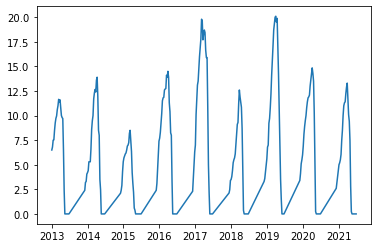

In [39]:
plt.plot(gm_melted['Washington'])

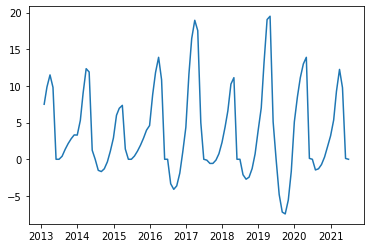

In [40]:
plt.plot(gm_resampled['Washington'])

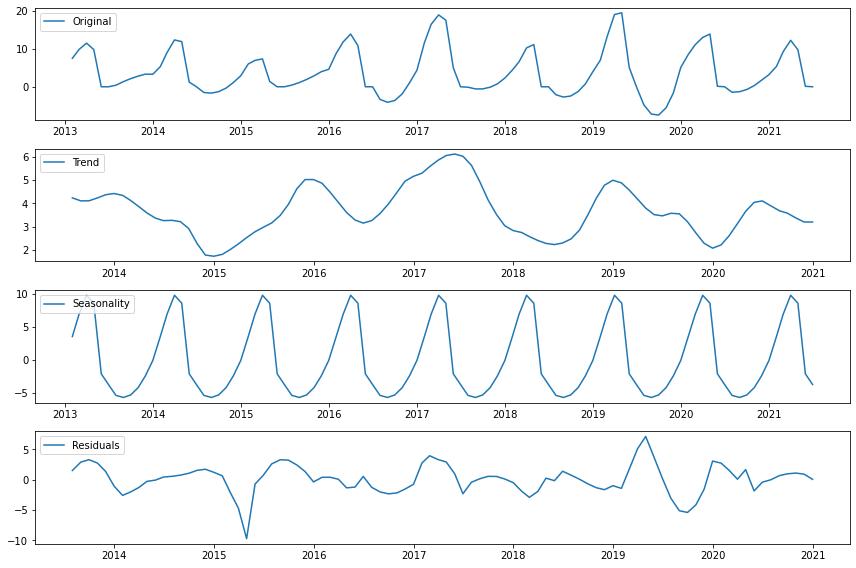

In [46]:
#Decomposing
decomposition = seasonal_decompose(gm_resampled['Utah'])

#Plot gathered statistics
plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(gm_resampled['Utah'], label='Original')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(decomposition.trend, label='Trend')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(decomposition.seasonal,label='Seasonality')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(decomposition.resid, label='Residuals')
plt.legend(loc='upper left')
plt.tight_layout()